# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="Tennis.app")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [5]:
for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: 0.04500000085681677
Total score (averaged over agents) this episode: -0.004999999888241291


When finished, you can close the environment.

In [7]:
#env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

In [5]:
from collections import namedtuple, deque
import ddpg_agent

In [6]:
from ddpg_agent import Agent as DDPGAgent, ReplayBuffer
import random
import torch
import time

In [7]:
class MADDPG:

    def __init__(self, random_seed):
        self.agents = [DDPGAgent(state_size,action_size,random_seed) for i in range(num_agents)]
        self.memory = ReplayBuffer(ddpg_agent.BUFFER_SIZE, ddpg_agent.BATCH_SIZE, random.seed(random_seed))

    def step(self, states, actions, rewards, next_states, dones, t):
        self.memory.add(states, actions, rewards, next_states, dones)

        for agent in self.agents:
            agent.step(self.memory, t)

    def act(self, states, add_noise=True):
        actions = np.zeros([num_agents, action_size])
        for i, agent in enumerate(self.agents):
            actions[i, :] = agent.act(states[i], add_noise)
        return actions
    
    ## Save the model along with some training information
    def save_checkpoint(self, checkpoint_name, i_episode, time_elapsed_str, scores, window_avg):
        checkpoint = {
            'ddpg_params': {
                'batch_size': ddpg_agent.BATCH_SIZE,
                'buffer_size': ddpg_agent.BUFFER_SIZE,
                'gamma': ddpg_agent.GAMMA,
                'lr_actor': ddpg_agent.LR_ACTOR,
                'lr_critic': ddpg_agent.LR_CRITIC,
                'tau': ddpg_agent.TAU,
                },
            'episodes': i_episode,
            'elapsed_time': time_elapsed_str,
            'scores': scores,
            'moving_avg': window_avg,
            }
        for i, agent in enumerate(self.agents):
            checkpoint["agent{}".format(i+1)] = {'actor_dict': agent.actor_local.state_dict(),
                                                 'critic_dict': agent.critic_local.state_dict()}
        
        print('\nSaving model ...', end=' ')
        torch.save(checkpoint, checkpoint_name)
        print('done.')
    def reset(self):        
        for agent in self.agents:
            agent.reset()

In [8]:
TARGET = 0.5
WINDOW_SIZE = 100

def train_maddpg(checkpoint_name = "test.pt", n_episodes=10000):
    scores_deque = deque(maxlen=WINDOW_SIZE)
    scores = []
    window_avg = []
    
    ## Perform n_episodes of training
    absolute_start_time = time.time()
    window_start_time = time.time()
    
    maddpg_agent = MADDPG(random_seed=0)
    
    for i_episode in range(1, n_episodes+1):  
        env_info = env.reset(train_mode=True)[brain_name]     
        states = env_info.vector_observations               
        score = np.zeros(num_agents)

        maddpg_agent.reset()
        t = 0
        # Intead of a max len, it should play until loose due to the fact that the best it play, 
        # it has more time to accumulate points
        while True:
            actions = maddpg_agent.act(states)
            env_info = env.step(actions)[brain_name]            
            next_states = env_info.vector_observations
            rewards = env_info.rewards         
            dones = env_info.local_done                         
            maddpg_agent.step(states, actions, rewards, next_states, dones, t)        
            states = next_states
            score += rewards 
            t +=1

            if any(dones):                                 
                break
        #print(t)
        score_max = np.max(score)
        scores.append(score_max)
        scores_deque.append(score_max)
        window_score = np.mean(scores_deque)
        window_avg.append(window_score)
        

        print('\rEpisode {}\tScore: {:.3f}\tWindow Score: {:.3f}'.format(i_episode, score_max, window_score), end="")  

        if i_episode % WINDOW_SIZE == 0:
            time_window = time.time() - window_start_time
            time_window_str = time.strftime('%Mm%Ss', time.gmtime(time_window))
            window_start_time = time.time()
            print('\r({}) Episode {}\tScore: {:.3f}\tWindow score: {:.3f}'.format(time_window_str, i_episode , score_max, window_score))

        if window_score >= TARGET:
            #maddpg_agent.save_weights()
            time_elapsed = time.time() - absolute_start_time
            time_elapsed_str = time.strftime('%Hh%Mm%Ss', time.gmtime(time_elapsed))
            maddpg_agent.save_checkpoint(checkpoint_name, i_episode, time_elapsed_str, scores, window_avg)
            print("\rSolved in episode: {} \tWindow score: {:.3f} \tTime elapsed: {}".format(i_episode , window_score, time_elapsed_str))
            break
    return scores , window_avg

In [ ]:
scores , window_avg = train_maddpg()

Episode 32	Score: 0.000	Window Score: 0.003

In [13]:
scores , window_avg = train_maddpg(checkpoint_name = "test_double_update.pt")

(00m47s) Episode 100	Score: 0.000	Window score: 0.002
(00m54s) Episode 200	Score: 0.000	Window score: 0.000
(00m55s) Episode 300	Score: 0.000	Window score: 0.000
(00m55s) Episode 400	Score: 0.000	Window score: 0.000
(00m55s) Episode 500	Score: 0.000	Window score: 0.000
(00m55s) Episode 600	Score: 0.000	Window score: 0.000
(00m59s) Episode 700	Score: 0.000	Window score: 0.003
(00m59s) Episode 800	Score: 0.000	Window score: 0.003
(00m55s) Episode 900	Score: 0.000	Window score: 0.000
(00m55s) Episode 1000	Score: 0.000	Window score: 0.000
(00m56s) Episode 1100	Score: 0.000	Window score: 0.000
(01m00s) Episode 1200	Score: 0.000	Window score: 0.005
(01m34s) Episode 1300	Score: 0.000	Window score: 0.031
(01m22s) Episode 1400	Score: 0.000	Window score: 0.029
(01m13s) Episode 1500	Score: 0.000	Window score: 0.025
(01m12s) Episode 1600	Score: 0.000	Window score: 0.019
(01m12s) Episode 1700	Score: 0.000	Window score: 0.017
(01m59s) Episode 1800	Score: 0.090	Window score: 0.066
(02m03s) Episode 19

In [14]:
scores , window_avg = train_maddpg(checkpoint_name = "test_decay.pt")

(00m47s) Episode 100	Score: 0.000	Window score: 0.001
(00m57s) Episode 200	Score: 0.000	Window score: 0.004
(00m55s) Episode 300	Score: 0.000	Window score: 0.000
(00m55s) Episode 400	Score: 0.000	Window score: 0.000
(00m55s) Episode 500	Score: 0.000	Window score: 0.000
(00m55s) Episode 600	Score: 0.000	Window score: 0.000
(00m58s) Episode 700	Score: 0.000	Window score: 0.001
(01m14s) Episode 800	Score: 0.000	Window score: 0.025
(01m03s) Episode 900	Score: 0.000	Window score: 0.007
(01m00s) Episode 1000	Score: 0.000	Window score: 0.006
(00m55s) Episode 1100	Score: 0.000	Window score: 0.000
(01m05s) Episode 1200	Score: 0.090	Window score: 0.011
(01m19s) Episode 1300	Score: 0.000	Window score: 0.030
(01m36s) Episode 1400	Score: 0.100	Window score: 0.052
(01m38s) Episode 1500	Score: 0.090	Window score: 0.058
(01m52s) Episode 1600	Score: 0.100	Window score: 0.080
(02m02s) Episode 1700	Score: 0.090	Window score: 0.095
(02m00s) Episode 1800	Score: 0.100	Window score: 0.093
(02m01s) Episode 19

### Evaluation

Three checkpoints:
* test_double_update.pt (two updates every step)
* test_clip.pt (clip gradients of critic)
* test_decay.pt (weight decay of critic of 1e-3)

In [10]:
def print_checkpoint(checkpoint):
    print("BATCH_SIZE: {}\nBUFFER_SIZE: {}\nGAMMA: {}\nLR_ACTOR: {}\
          \nLR_CRITIC: {}\nTAU: {}\nsolved in: {} episodes\
          \ntraining time: {}\nWindow average {}".format(checkpoint['ddpg_params']['batch_size'],
                                                          checkpoint['ddpg_params']['buffer_size'],
                                                          checkpoint['ddpg_params']['gamma'],
                                                          checkpoint['ddpg_params']['lr_actor'],
                                                          checkpoint['ddpg_params']['lr_critic'],
                                                          checkpoint['ddpg_params']['tau'],
                                                          checkpoint['episodes']-100,
                                                          checkpoint['elapsed_time'],
                                                          checkpoint['moving_avg'][-1]))

In [11]:
checkpoint = torch.load('test_clip.pt',map_location={'cuda:0': 'cpu'})
maddpg_agent = MADDPG(random_seed=0)
maddpg_agent.agents[0].actor_local.load_state_dict(checkpoint['agent1']['actor_dict'])
maddpg_agent.agents[1].actor_local.load_state_dict(checkpoint['agent2']['actor_dict'])
print_checkpoint(checkpoint)

BATCH_SIZE: 256
BUFFER_SIZE: 100000
GAMMA: 0.99
LR_ACTOR: 0.0001          
LR_CRITIC: 0.001
TAU: 0.001
solved in: 2115 episodes          
training time: 00h46m12s
Window average 0.5020000074803829


In [ ]:
for i in range(1, 6):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        #actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = maddpg_agent.act(states, False)          # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

In [ ]:
env.close()

### Plots of scores

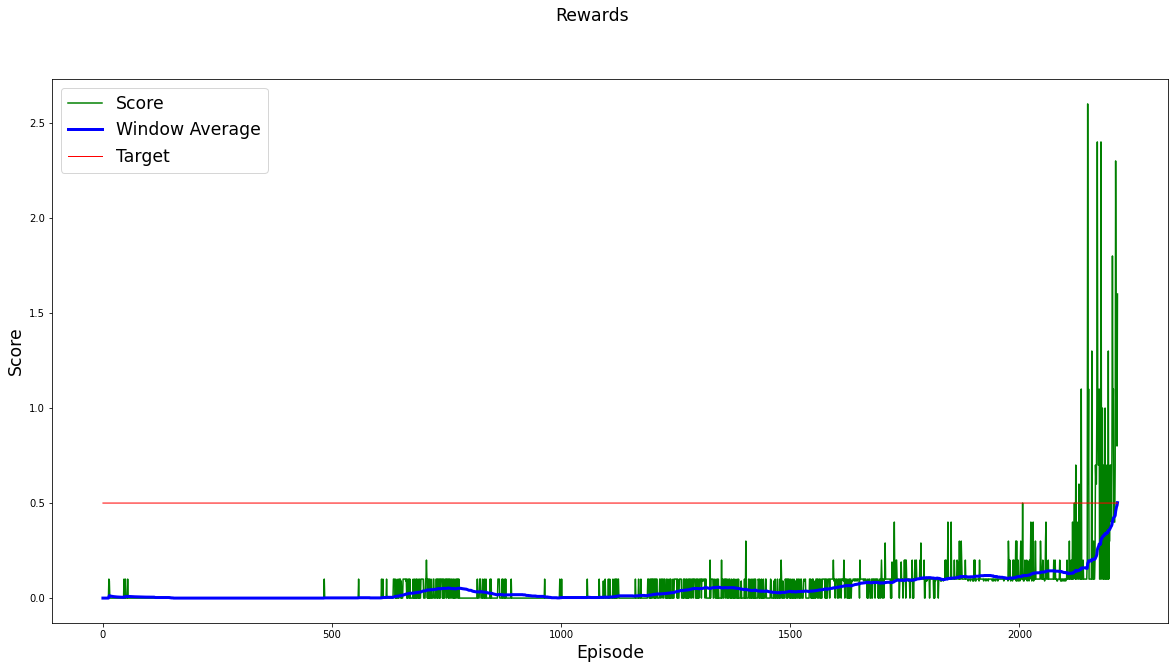

In [12]:
import matplotlib.pyplot as plt

TARGET = 0.5

scores_mean = checkpoint['scores']
moving_avg_mean = checkpoint['moving_avg']

target = [TARGET] * len(checkpoint['scores']) 

# Plot the main graph with the scores and moving average
fig = plt.figure(figsize=(20,10))
fig.suptitle('Rewards', fontsize='xx-large')

ax = fig.add_subplot(111)
ax.plot(scores_mean, label='Score', color='Green')
ax.plot(moving_avg_mean, label='Window Average',
        color='Blue', linewidth=3)
ax.plot(target, label='Target', color='Red', linewidth=1 )
ax.set_ylabel('Score', fontsize='xx-large')
ax.set_xlabel('Episode', fontsize='xx-large')
ax.legend(fontsize='xx-large', loc='upper left')

plt.show()